In [ ]:
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [ ]:
df = pd.read_csv('depression_data.csv')
df.shape
df= df[:10000]

In [ ]:
df.shape

(10000, 5)

In [ ]:
# Let's have a look at the data
df.head()

,Unnamed: 0,Unnamed: 0.1,Comments Text,text,label
0,0,0,"So, when you ask what the two illnesses are......",just finished my second exam only one more to go,0
1,1,1,"In addition, people with BPD quite often have ...",i was so much happier in prison ever since i c...,1
2,2,2,"Borderline Personality Disorder, like all othe...",can depression be cured by positivity anxiety ...,1
3,3,3,LONG ANSWER: Bipolar disease is caused by a ch...,rt ur wcw takes depression naps a day worrie...,1
4,4,4,Well think of bipolar as a rollar coaster you ...,reeselasher you guys are hilarious why not jus...,0


We can see that the most relevant column for us is content and replyContent and the score as well.

In [ ]:
# Let's check for missing values
df.isnull().sum()

Unnamed: 0          0
Unnamed: 0.1        0
Comments Text    2855
text                0
label               0
dtype: int64

There are missing values in some of the columns but Content and score don't have a missing value. We can also look at the class balance.

We will be alloting three classes:-
1. Positive (Score: 4-5)
2. Neutral (Score: 3)
3. Negative (Score: 1-2)

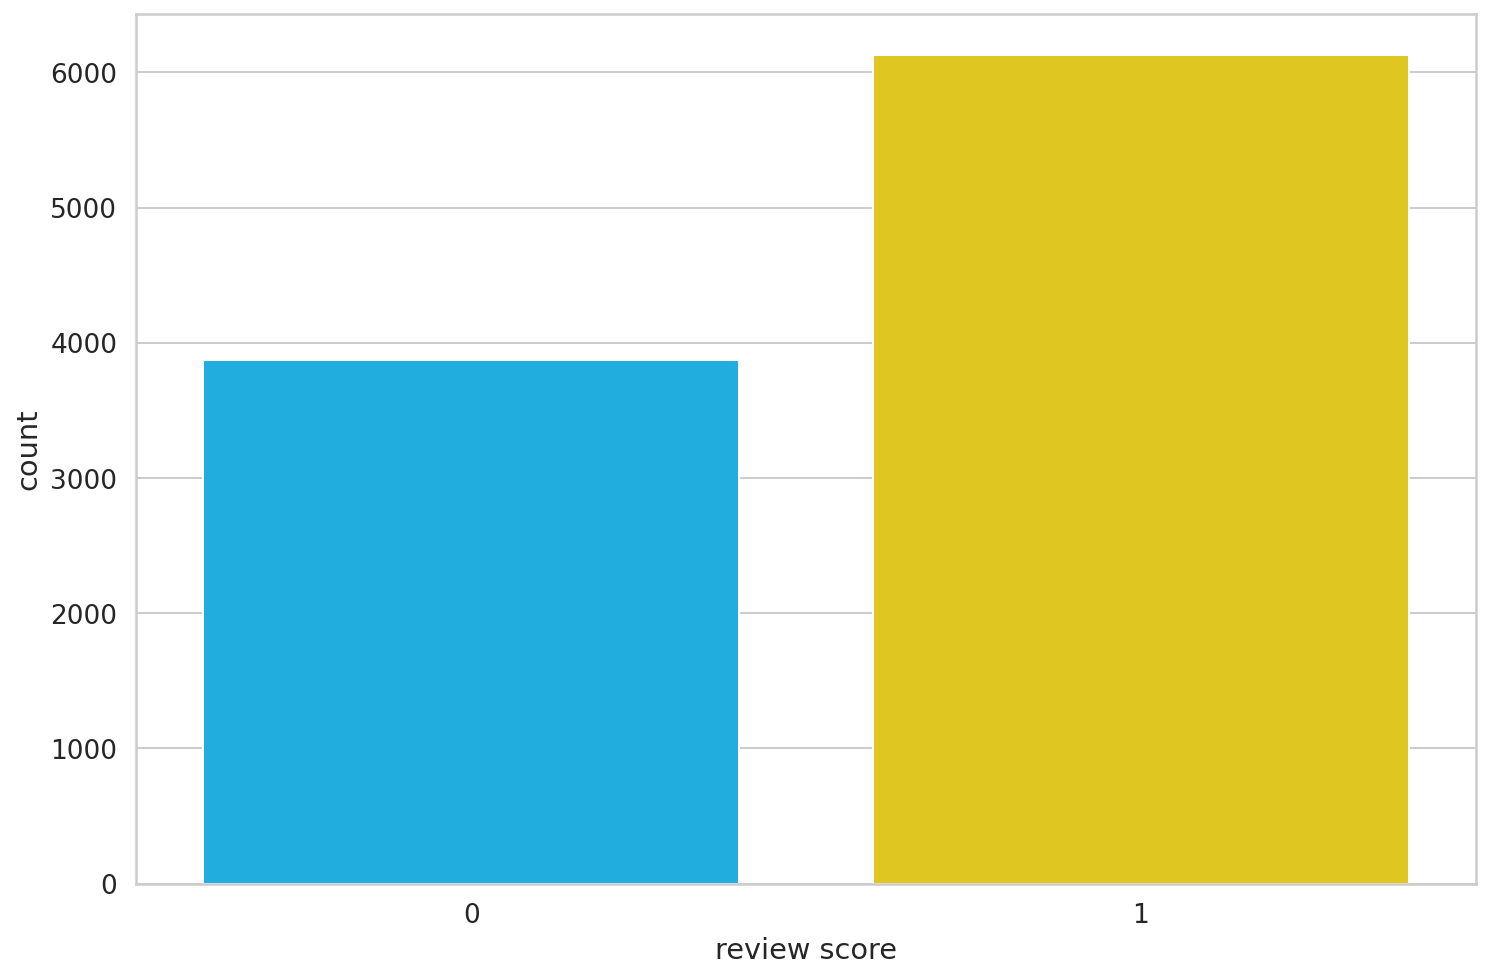

In [ ]:
# Let's have a look at the class balance.
sns.countplot(df["label"])
plt.xlabel('review score');

In [ ]:
# Function to convert score to sentiment
def to_sentiment(rating):

    rating = int(rating)

    # Convert to class
    if rating == 0:
        return 0
    else:
        return 1

# Apply to the dataset
df['sentiment'] = df["label"].apply(to_sentiment)

[Text(0, 0, 'negative'), Text(0, 0, 'positive')]

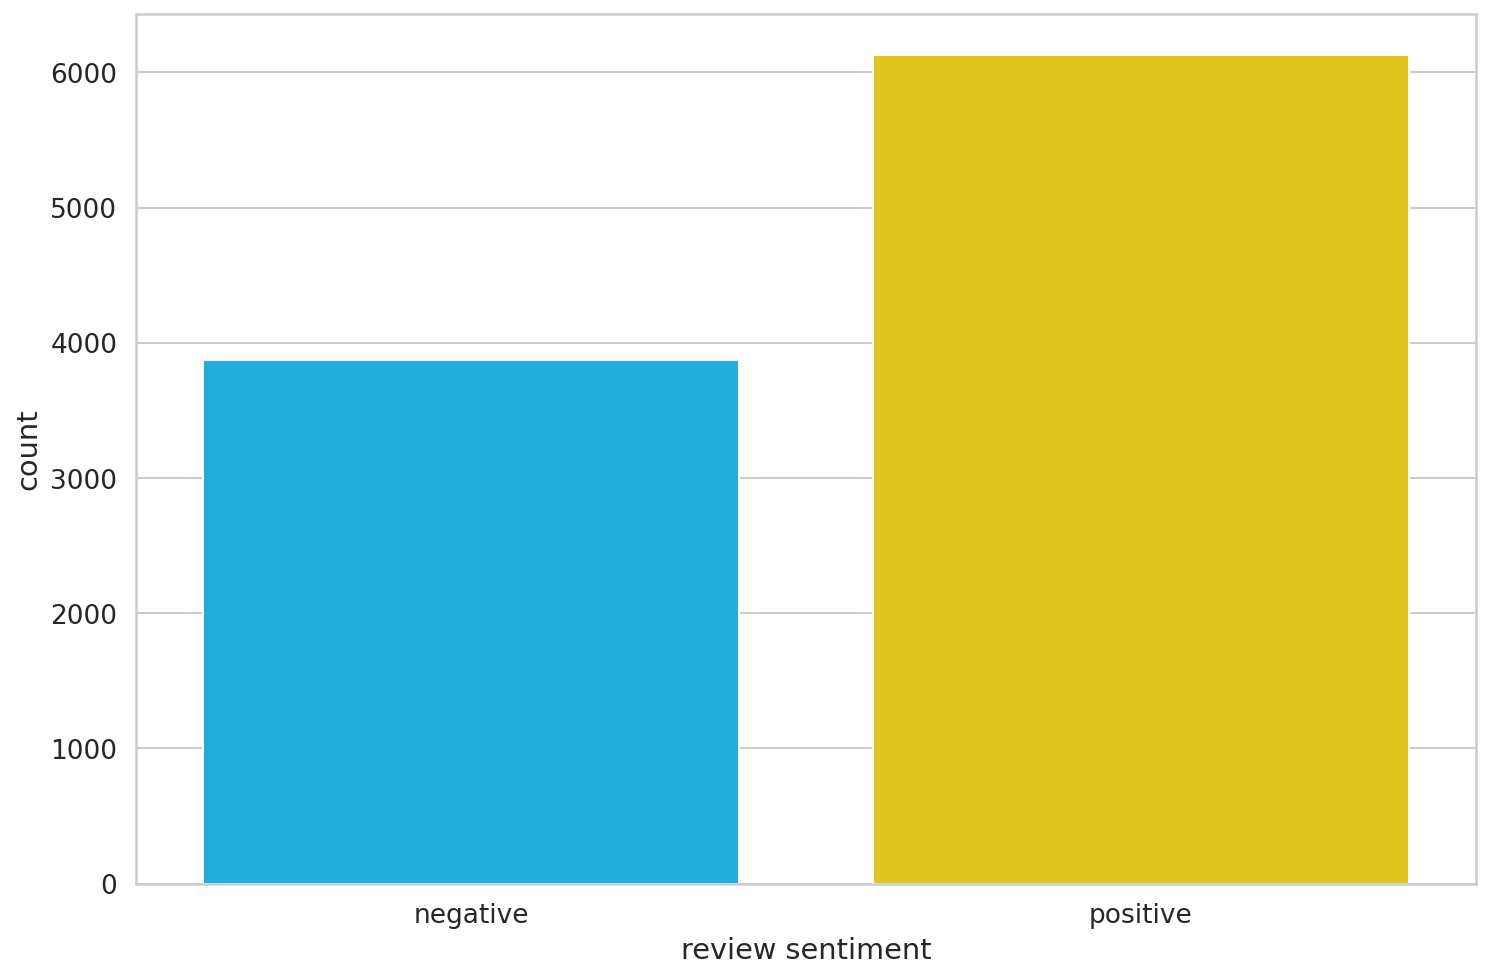

In [ ]:
# Plot the distribution
class_names = ['negative', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [ ]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [ ]:
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in df["text"]:
    if isinstance(txt, str):
        tokens = tokenizer.encode(txt, max_length=512)
        token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

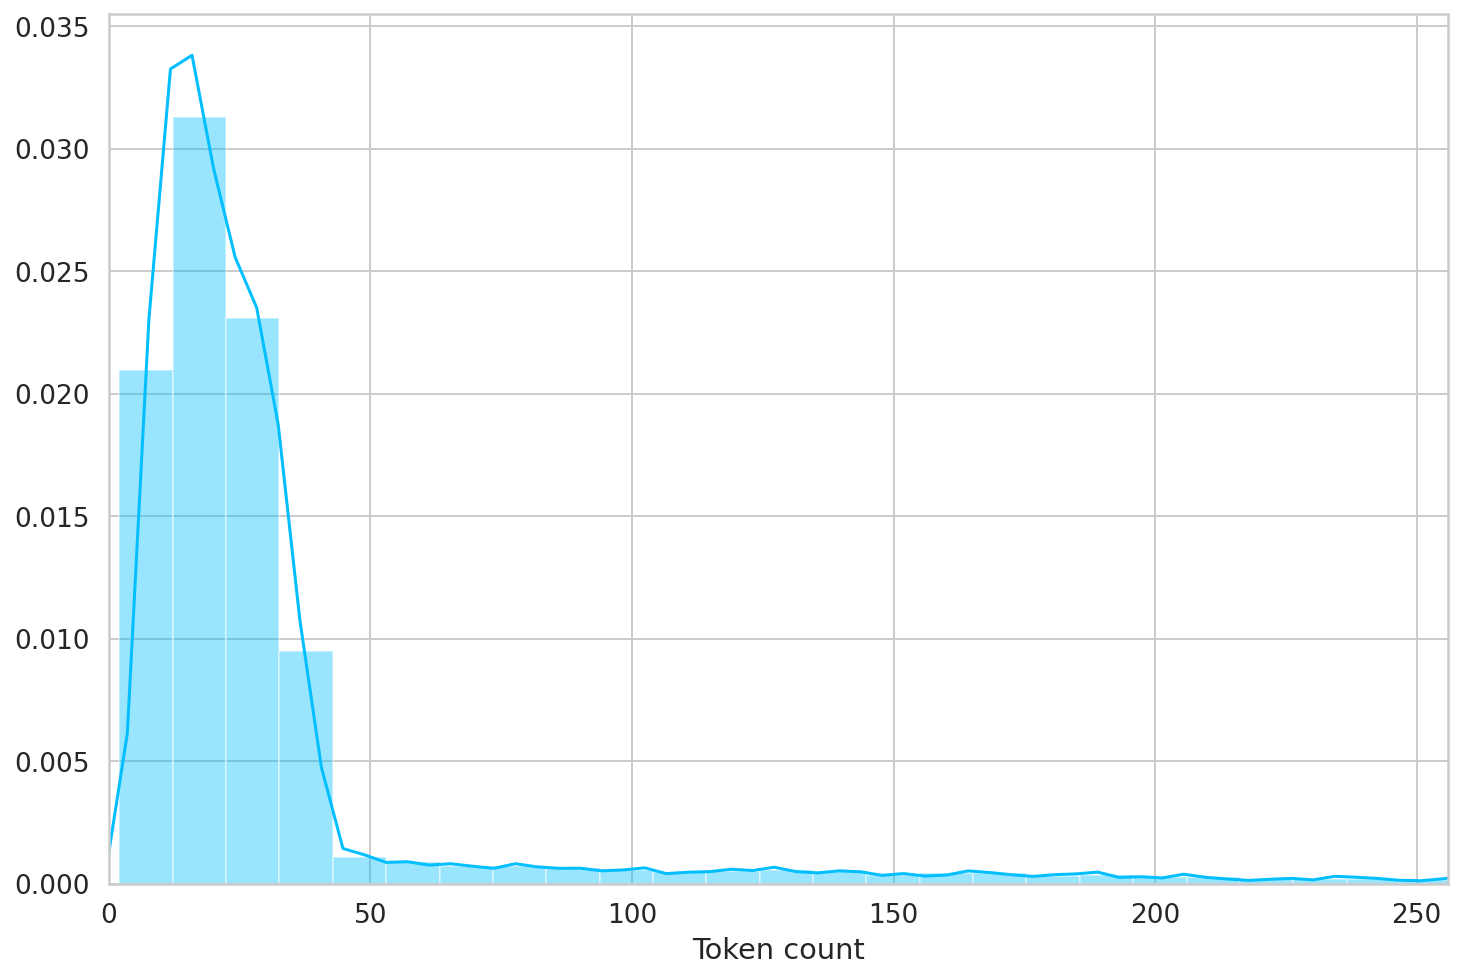

In [ ]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,Comments Text,text,label,sentiment
0,0,0,"So, when you ask what the two illnesses are......",just finished my second exam only one more to go,0,0
1,1,1,"In addition, people with BPD quite often have ...",i was so much happier in prison ever since i c...,1,1
2,2,2,"Borderline Personality Disorder, like all othe...",can depression be cured by positivity anxiety ...,1,1
3,3,3,LONG ANSWER: Bipolar disease is caused by a ch...,rt ur wcw takes depression naps a day worrie...,1,1
4,4,4,Well think of bipolar as a rollar coaster you ...,reeselasher you guys are hilarious why not jus...,0,0
...,...,...,...,...,...,...
9995,9995,9995,NaN,medication suggestions was taking effexor for ...,1,1
9996,9996,9996,NaN,kristencampisi hahahhaha yeah wow didnt mean f...,0,0
9997,9997,9997,NaN,why is everything so hard im having a really b...,1,1
9998,9998,9998,NaN,heading to a wedding,1,1


In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(8000, 6) (1000, 6) (1000, 6)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df["text"].to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [ ]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [ ]:
# Number of iterations
EPOCHS = 5

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-5,correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.471170508608222 accuracy 0.7745
Val   loss 0.4192589107486937 accuracy 0.8130000000000001

Epoch 2/5
----------
Train loss 0.2774025138989091 accuracy 0.89125
Val   loss 0.5487987011493671 accuracy 0.8210000000000001

Epoch 3/5
----------
Train loss 0.15375545921968295 accuracy 0.955375
Val   loss 0.8747275192364459 accuracy 0.805

Epoch 4/5
----------
Train loss 0.08628835339006037 accuracy 0.979625
Val   loss 0.9376226355994327 accuracy 0.8230000000000001

Epoch 5/5
----------
Train loss 0.0580267013591947 accuracy 0.9872500000000001
Val   loss 1.0361711287035769 accuracy 0.8170000000000001

CPU times: user 20min 7s, sys: 3.99 s, total: 20min 11s
Wall time: 20min 17s


The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

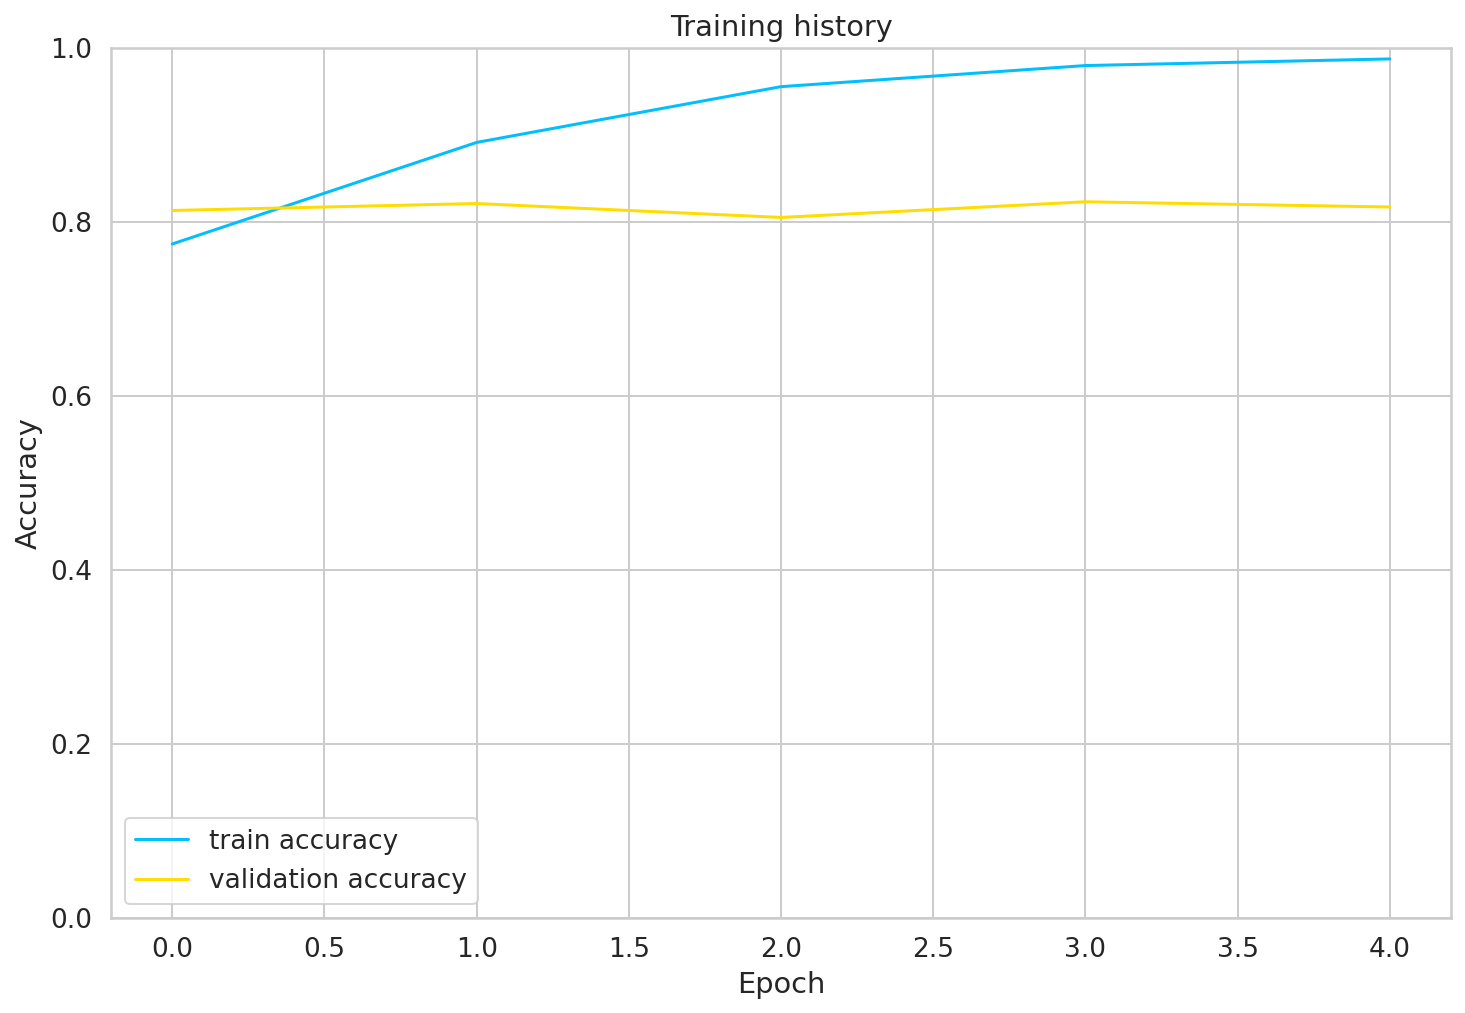

In [ ]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);